# An introduction to Shap Values and Partial Dependence Plots with Applications to the CPG Industry 

## Motivation

While accurate predictions are an important part of business strategy their utility is limited without an accompanying means of influencing the outcome. Suppose we have a model which predicts whether a shipment from a manufacturer to a retailer will arrive on time. If our model only predicts the shipment will be late but doesn't also inform us which factors are contributing to that prediction, then it isn't helpful in preventing the shipment from being late and the assoicated losses. The CPG industry (Consumer Packaged Goods) is the industry of manufacturing low cost and fast selling products such as soft drinks, tooth paste, candies, over-the-counter drugs, etc. There are many important factors contributing to a successful business in the CPG industry, and timing is certainly one of them. Hence it is crucial to know which features can be leveraged to increase the number of on-time deliveries.

The good news is that in predictive modeling there are ways to meausre the contribution of each feature to a given prediction, so action can be taken to affect the outcome. Techniques which leverage importance of features for predicions are called "feature importance" or "inference" techniques in the machine learning and statistics literature, respectively. In this article, we discuss two well known methods for feature importance, how they are calculated, how to apply them, as well as the pros and cons of each. While the discussion is focused on applications to the CPG Industry we will be mathematically rigourous.

## Partial Dependence Plots (PDPs)

### Example

Suppose we are a manufacturer who is predicting how much revenue can be expected from a retailer based on two features: Discount $(D)$ and Size $(S)$. Here $D$ refers to any discount given to the retailer, and $S$ indicates the size of the retailer such as number of stores, number of employees, etc. Furthermore suppose a simple linear model was fitted for the revenue $R$ based on these two features yielding $R=D+2S+1$. The "bias term" of 1 can be interpreted as residual revenue in the absence of size and discount coming from other factors. Assuming that the data was transformed to be on the same scale prior to the fit, we can interpret this to mean that the size of the manufacturer is twice as important as whether or not they got a discount. Linear models have the advantage that this interpretation is clear provided the features are independent. Consider now a more general model of the form $R=f(S,D)$ where $f$ is some (nonlinear) function of discount and size. We can use partial dependence plots to gain an insight similar to the above provided that $S$ and $D$ are independent.

${\textbf{Definition.}}$ The partial dependence of $R$ on $D$ is given by $PD_R(D)=E[f(S,D)\vert D]$ where $S$ is thought of as random, $D$ as fixed, and $E$ denotes expected value.   

${\textbf{Remark.}}$ For the linear example above we have $PD_R(D)=E[D+2S+1\vert D]=D+2E[S\vert D]+1=D+2E(S)+1$, assuming $S$ and $D$ are independent, since $E[D\vert D]=D$ and $E[S\vert D]=E(S)$. The latter is a linear function of $D$, with slope 1. This is clearly not informative since the model is already linear, but nonetheless is consistent with what we would expect. If we assume in addition that $S$ and $D$ are independent and drawn from a Normal distribution $\mathcal{N}(1,0.25)$ this becomes $PD_R(D)=E[D+2S+1\vert D]=D+3$ and similarly $PD_R(S)=2S+E(D)+1=2S+2$ 

We can verify these relationships by plotting the partial dependence functions below using the Scikit-Learn partial dependence library.

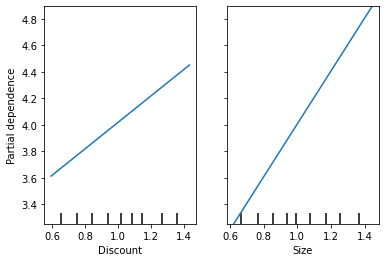

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.inspection import plot_partial_dependence

X = np.random.normal(1, 0.25, (200,2))
    
d = X[:,0]

s = X[:,1]


r=d+2*s+1

reg = LinearRegression().fit(X, r)

plot_partial_dependence(reg, X, features=[0,1], feature_names=['Discount', 'Size'])



E.g. if $R=D^4+2S^2+1$ so that the relationship is no longer linear then neither are the PDPs:

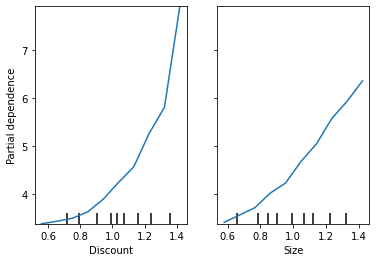

In [2]:
from sklearn.ensemble import RandomForestRegressor


X = np.random.normal(1, 0.25, (200,2))
    
d = X[:,0]

s = X[:,1]



r=d**4+2*(s**2)+1

reg = RandomForestRegressor().fit(X, r)

plot_partial_dependence(reg, X, features=[0,1], feature_names=['Discount', 'Size'], grid_resolution=10)



Problems begin to emerge when correlated terms appear. E.g. $R=D^2+S+1$ where $S=D$.

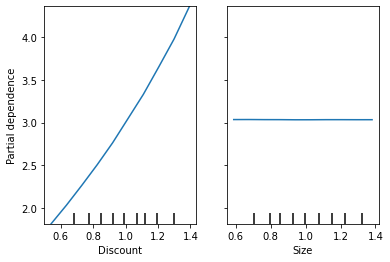

In [3]:
X = np.random.normal(1, 0.25, (200,2))
    
d = X[:,0]

s = d

r=d**2+s+1

reg = RandomForestRegressor().fit(X, r)

plot_partial_dependence(reg, X, features=[0,1], feature_names=['Discount', 'Size'], grid_resolution=10)



Hence when using partial dependence plots one should exercise caution with multicollinearity. In this example it would appear that increasing size has no affect on revenue! A good way to test for multicollinearity when performing any kind of regression is to refit the model on different random samples to see how much the regression coefficients vary each time. Alternatively, if the regression assumes a data generating mechanism (E.g. classical linear regression), then one can examine the p-values and confidence intervals for the coefficients.

So far we have limited the discussion to examining the partial dependence of one covariate at a time. We can also examine the PDP of two or more covariates. E.g. consider $R=D^2+S+7N+1$ where we added an additional feature $N$ to denote the number of employees. Assuming independent features we have that $$PD_R(S,D)=E[D^2+S+7N+1\vert D,S]=D^2+S+7E(N)+1.$$

If the features are drawn from a normal distribution $\mathcal{N}(1,0.25)$, we have that $PD_R(S,D)=D^2+S+8$. We simulate this and plot a countour map where the numbers indicate the direction of increasing revenue.

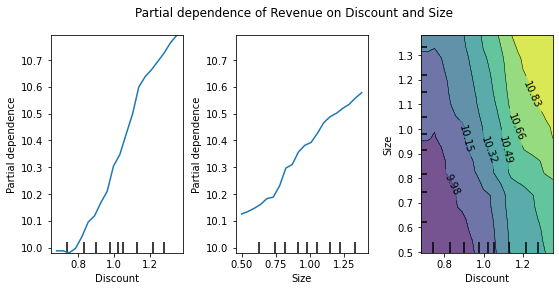

In [4]:
from sklearn.inspection import partial_dependence


X = np.random.normal(1, 0.25, (200,3))
    
d = X[:,0]

s = X[:,1]

n = X[:,2]

 

r=d**2+s+7*n+1

reg = RandomForestRegressor().fit(X, r)


features = [0,1, (0,1)]

_, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = plot_partial_dependence(reg, X, features, feature_names=['Discount', 'Size', 'No. Employees'], n_jobs=3, grid_resolution=20,ax=ax)

display.figure_.suptitle(
'Partial dependence of Revenue on Discount and Size')
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

This way the problem of multicollinearity can be circumvented if the collinear terms are grouped together in the contor plot. An obvious con is that we may not a priori know which terms are correlated and in addition, the above plots become infeasible to visualize when the numer of indpendent features is more than three. 

All of the above examples came from regerssion where we had an explicit formula for the dependence of revenue on the features, and hence the need for partial dependence plots is not clear. However, these plots are very useful when the model is not merely a regression and is non-parametric such as a tree based model, a neural network, or any kind of ensemble. Furthermore, despite the fact that tree based models give feature importances, these are different from partial dependence and do not indicate whether the target (in our case revenue), increases or decreases when the feature is increased or decreased. 

## Shap Values

While PDPs give a good aggregated view of how one feature impacts the target, often times we want to know the contribution of each feature to the target at a specific data sample. 

E.g. Suppose we are predicting revenue based on size and discount, and our model tells us that when size is 6000 units and the discount is 1000 USD, revenue will be 10000 USD. If we are using e.g. a tree based regression model, and we would like to know the exact contribution of each feature to this prediction then we cannot rely on PDPs, since by definition they only tell us the expected revenue when aggregated over the complementary features.

This is where Shap values are useful, as they provide an answer to this question.

## Idea

Consider again for illustration the linear model from above $R=D+2S+1$. We wish to compute the Shap values. Each feature has a Shap value. Since Shap values tell us the contribution of each feature for a given prediction, they themselves depend on the features and are computed the following way.

To find the Shap value of a given feature, we average the differences of including and excluding that feature over subsets of the set of all features minus the given feature, which have the same size (cardinality). E.g. for the feature $S$ we consider the set $\{S,D\}-\{S\}=\{D\}$, and the only subsets of the latter are $\{D\}$ and the empty set. We must decide what it means to "exclude features". Excluding a feature means averaging over it. Hence, when we remove all features (corresponding to the empty set), we are averaging over all features being left with what is called the baseline, denoted by $BASE$. In this case we have that $BASE=E[R(S,D)]=1+2(1)+1=4$. In practice, the baseline is estimated by averaging the model predictions. Furthermore,

$$\underbrace{\varphi_S(s,d)}_{\mbox{Shap value for size}}=\underbrace{\frac{1}{2}\big (E[R(s,d)\vert s]-BASE \big)}_{\mbox{size vs. baseline}}+\underbrace{\frac{1}{2}\big(R(s,d)-E[R(s,d)\vert d] \big)}_{\mbox{size vs. discount}}.$$

Similarly,

$$\underbrace{\varphi_D(s,d)}_{\mbox{Shap value for discount}}=\underbrace{\frac{1}{2}\big (E[R(s,d)\vert d]-BASE \big)}_{\mbox{discount vs. baseline}}+\underbrace{\frac{1}{2}\big(R(s,d)-E[R(s,d)\vert s] \big)}_{\mbox{discount vs. size}}.$$

Notice that 

$$R(s,d)-BASE=\varphi_S(s,d)+\varphi_D(s,d)$$

which justifies how Shap values give individual feature contribution for a given prediction, explaining the difference between the prediction and the baseline.

${\textbf{Remarks:}}$ 

-The factor $\frac{1}{2}$ ensures that the Shap values add up according to the formula above and does not come from the weight assigned to subsets of the same size, since in this example there is only a single subset of size 0 and 1 respectively, corresponding to each term in the summation.

-We intentionally use lower case arguments for Shap values.

-As can be seen above, the Shap values simply compare the effect of removing the feature under consideration from the prediction averaged over all combinations. In this example, $\varphi_D(s,d)=d-1$ and $\varphi_S(s,d)=2s-2$, which is not informative because we are dealing with a simple linear model, but this calculation can (in theory) be applied to any supervised learning problem! 

-To compute Shap values for a general supervised learning problem, one would need to perform a huge number of summations which quickly becomes infeasible. Fortunately, there are tricks for estimation of Shap values which exploit the particular model structure in question.


## How to Interpret Shap Values

Shap values must be interpreted with care as we show. E.g. By the calculations above we have that  $\varphi_S(0.5,0.5)=2(0.5)-2=-1$ and $\varphi_D(0.5,0.5)=0.5-1=-0.5$, despite the fact that increasing size or discount increases revenue. This is due to the fact that the particular point values are less than the average value of the revenue over the features.

Hence Shap values answer the question "For a paricular feature, and a corresponding model output, why is the output different from the average output (over the features, i.e. base value), and what is the contribution of each feature for this difference?" 

With the example above we have $R(0.5,0.5)=2.5$ which is smaller than the expected value over the features of 4. The contribution of $\varphi_S$ to this difference is -1 and -0.5 for $\varphi_D$.

Next we use the Python library SHAP to give some examples. E.g. let's start with the linear model above 

$$R=D+2S+1.$$

We will fit a linear regression to data generated by the above formula by drawing samples from a $\mathcal{N}(1,0.25)$ distribution for both discount and size.

In [5]:
import pandas as pd
import shap
from sklearn.linear_model import LinearRegression

X = np.random.normal(1, 0.25, (200,2))
    
d = X[:,0]

s = X[:,1]


X = pd.DataFrame({'Discount':d, 'Size':s})



r=d+2*s+1

reg = LinearRegression().fit(X, r)

shap.initjs()



model = reg


ex = shap.KernelExplainer(model.predict, X)


shap_values = ex.shap_values(X.iloc[0,:])




shap.force_plot(ex.expected_value, shap_values, X.iloc[0,:])

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In the above we explained the difference between the average revenue and the predicted predicted. The values for Size and Discount are the feature values (not Shap values!), and the predicted value is in bold. The predicted value is higher than the baseline, and the contributing factor to this is Discount, as the Shap value for it is positive indicated by the red color. 

In [6]:
print("Shap value for Discount is {0} and Shap value for Sales is {1}.".format(shap_values[0],shap_values[1]))

Shap value for Discount is 0.2701057654445038 and Shap value for Sales is -0.09112327759399763.


We can use the SHAP library to compute Shap values pointwise across different feature values $(S,D)$:

In [7]:

shap_values = ex.shap_values(X)


shap.force_plot(ex.expected_value, shap_values, X)


Since there is no natural ordering of the observations on the x-axis, an option for this must be selected. We chose to order the observations by similarity since this can be thought of as a way of grouping the features based on whether or not their Shap values are close.

Taking the mean absolute value of the Shap values for each feature and plotting this in a bar plot gives us:

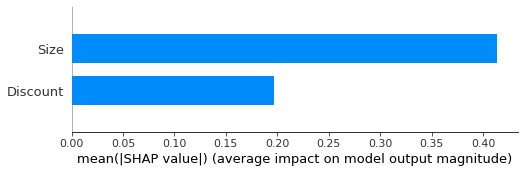

In [8]:
shap.summary_plot(shap_values, X, plot_type="bar")

The aggregated absolute value of Shap values above is consistent with the interpretation from the coefficients of the linear models. 

## CPG Industry Case Study

Here we consdier a case study motivated by a real world problem from the CPG industry which was addressed by Aimpoint Digital. Going back to the topic of shipping from a manufacturer to the retailer, we would like to know which shipments will be on time and how to intervene if it is thought a shipment will arrive late. Although the original work produced by Aimpoint included three different stages of the business cycle, and a model was procuded for each stage, for simplicity we are considering a single stage.

Setup: Suppose we obtain the dataset below which was extracting from the client's databse, cleaning joining and preprocessing is the following:

-868 columns: 62 carriers, 800 retailers, 3 regions, miles, weight, and a column indicating whether the shipment was late (called late where 1="late" and 0="not late").

The regions indicate the location of the shipment and are: "Mid-Atlantic", "Central", "Southeast", and "West". Since the regions are mutually exclusive, "West" has been omitted from the columns to avoid linearly dependent columns. 

-10000 rows.

The categorial data (carriers, retailers, and regions) was one-hot encoded, and the numerical data was standardized by subtracting its mean and dividing by the standard deviation column wise. There are no missing values.

Below we explore the data:



In [9]:
import pandas as pd
import numpy as np

df = pd.read_csv('cpg_demo.csv')

Let's look for the number of late shipments. The percantage of late shipments is:

In [10]:
df['late'].sum()/len(df)

0.0374

From the above we see that there is a class imbalance problem since most shipments are not late. Before we identify which features are important for preventing a shipment to be late, we would like to have a model which at the very least performs better than the baseline. We can take as our baseline a model which predicts that the probability of a shipment arriving late is simply the proportion of late obesrvations, i.e. 0.0374. We can use the log loss as our performance metric so we don't have to worry about under or over sampling, as our objective is feature importance and not classification. I.e. we will be optimizing well calibrated probabilities of the event of being late. 

In [11]:
X, y = df.drop(columns=['late']), df['late']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

We have a huge number of features, likely many of which are not informative so let's use a linear model and feature importance extracted from that to remove the non informative ones. It makes sense to use e.g. lasso regularized logistic regression for feature selection, where the strength of the regualrization is determined from cross validation on the training set. Since we are dealing with a heavily imbalanced data set, we will use the (negative) log loss as the cross validation scoring metirc. 

In [13]:
from sklearn.linear_model import LogisticRegressionCV



reg_lin = LogisticRegressionCV( penalty='l1', solver='saga', scoring='neg_log_loss')


reg_lin.fit(X_train,y_train)


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

LogisticRegressionCV(penalty='l1', scoring='neg_log_loss', solver='saga')

In [14]:
from sklearn.metrics import log_loss

print("Our reg. Log. reg. test log loss is {}".format(log_loss(y_test,reg_lin.predict_proba(X_test)[:,1])))
print("The baseline test log loss is {}".format(log_loss(y_test,np.repeat(0.0374,len(X_test)))))


Our reg. Log. reg. test log loss is 0.047603848721535835
The baseline test log loss is 0.1562252222021652


In [15]:
features = X.columns

Let's look at the feature importances which are highest in absolute value.

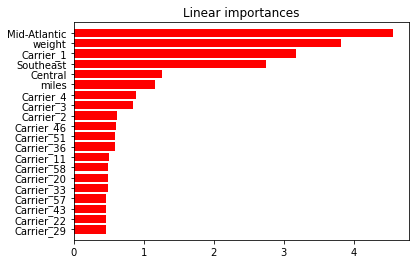

In [56]:
abs_importances = np.absolute((reg_lin.coef_)[0])

indices = np.argsort(abs_importances)

top20 = indices[-20:]

linear_top20_features = [features[i] for i in top20]


# Plot the feature importances of the forest
plt.figure()
plt.title("Linear importances")
plt.barh(range(20), abs_importances[top20], color="r", align="center")

plt.yticks(range(20), linear_top20_features)
plt.ylim([-1, 20])
plt.show()

In [60]:
linear_top20_features.reverse()

From the above graph it looks like the first eight are the most informative, let's have a look

In [61]:
linear_top20_features[0:8]

['Mid-Atlantic',
 'weight',
 'Carrier_1',
 'Southeast',
 'Central',
 'miles',
 'Carrier_4',
 'Carrier_3']

In case there are nonlinear hidden relationships, we fit a random forest and see what insight can be gained from a nonlinear model.

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=4,random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=0)

In [20]:
print("Our random forest's test log loss is {}".format(log_loss(y_test,forest.predict_proba(X_test)[:,1])))
print("The baseline test log loss is {}".format(log_loss(y_test,np.repeat(0.0374,len(X_test)))))

Our random forest's test log loss is 0.13915461585064248
The baseline test log loss is 0.1562252222021652


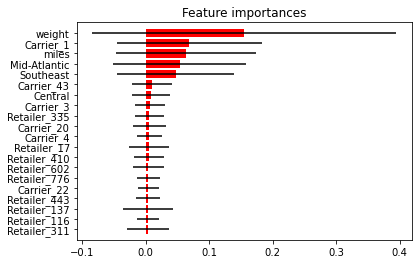

In [63]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)

top20 = indices[-20:]

forest_top20_features = [features[i] for i in top20]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(20), importances[top20],
       color="r", xerr=std[top20], align="center")

plt.yticks(range(20), forest_top20_features)
plt.ylim([-1, 20])
plt.show()

In [64]:
forest_top20_features.reverse()


The top seven features for the random forest also appear among top eight the linear model.

In [65]:
forest_top20_features[0:7]



['weight',
 'Carrier_1',
 'miles',
 'Mid-Atlantic',
 'Southeast',
 'Carrier_43',
 'Central']

In [66]:
imp_features = set(forest_top20_features[0:7]).union(set(linear_top20_features[0:8]))

In [67]:
imp_features

{'Carrier_1',
 'Carrier_3',
 'Carrier_4',
 'Carrier_43',
 'Central',
 'Mid-Atlantic',
 'Southeast',
 'miles',
 'weight'}

We can use PDPs to gain instight into the effect of the above features on the probability of a shipment arriving late. We will focus on both short term and long term business strategies infomred from the PDP plots. However, before intrepreting the PDP plots, we will examine if there is any significant multicorrelation present among the features.

In [26]:
abs_corr = X_train.corr().abs()
corr = (abs_corr.unstack()).sort_values(kind="quicksort")

corr[corr>0.5]

Carrier_0     Carrier_0       1.0
Retailer_368  Retailer_368    1.0
Retailer_799  Retailer_799    1.0
Retailer_229  Retailer_229    1.0
Retailer_228  Retailer_228    1.0
                             ... 
Retailer_507  Retailer_507    1.0
Retailer_506  Retailer_506    1.0
Retailer_505  Retailer_505    1.0
Retailer_516  Retailer_516    1.0
miles         miles           1.0
Length: 867, dtype: float64

The only pairs of correlated variables are the duplicate pairs, so we are good.

In the contour plots below, the darker colors indicate lower levels of the probability of being late. 

### Short Term Business Insights:

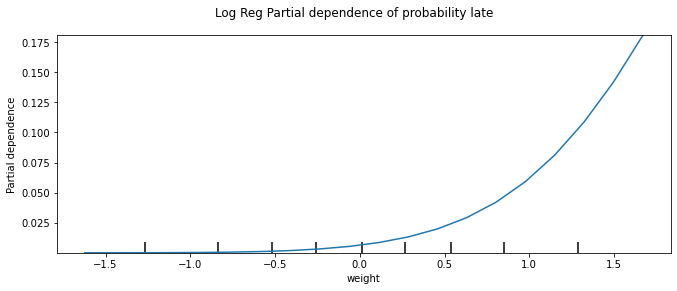

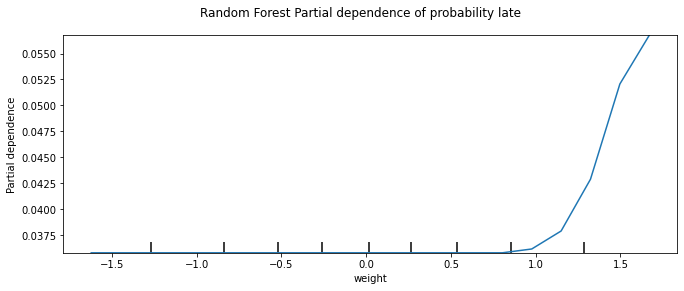

In [27]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence


weight = list(features).index('weight')



features_plot = [weight]

_, ax = plt.subplots(ncols=1, figsize=(11, 4))
display = plot_partial_dependence(reg_lin, X_train, features_plot, feature_names=features, n_jobs=3, grid_resolution=20,ax=ax)

display.figure_.suptitle('Log Reg Partial dependence of probability late')
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

features_plot = [weight]

_, ax = plt.subplots(ncols=1, figsize=(11, 4))
display = plot_partial_dependence(forest, X_train, features_plot, feature_names=features, n_jobs=3, grid_resolution=20,ax=ax)

display.figure_.suptitle('Random Forest Partial dependence of probability late')
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

Both models indicate increasing weight leads to an increase in the probability of a shipment being late. A short term business strategy is to split up large shipments into smaller ones to reduce this probability. Noiice how the logistic regression produces a curve instead of a line, despite being a linear model. This is because the sigmoid function is nonlinear. 

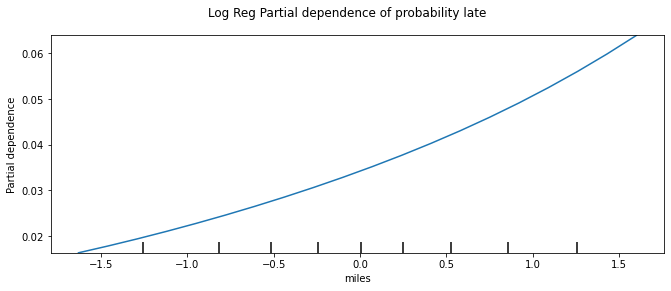

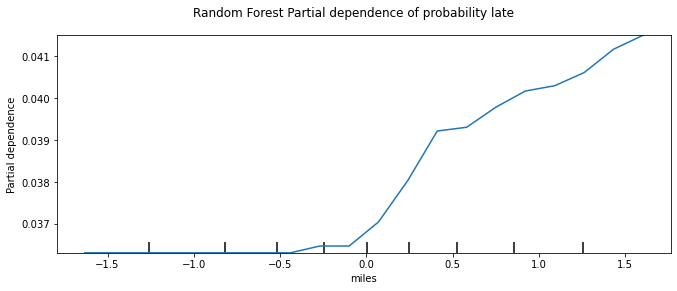

In [28]:
miles = list(features).index('miles')



features_plot = [miles]

_, ax = plt.subplots(ncols=1, figsize=(11, 4))
display = plot_partial_dependence(reg_lin, X_train, features_plot, feature_names=features, n_jobs=3, grid_resolution=20,ax=ax)

display.figure_.suptitle('Log Reg Partial dependence of probability late')
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)


_, ax = plt.subplots(ncols=1, figsize=(11, 4))
display = plot_partial_dependence(forest, X_train, features_plot, feature_names=features, n_jobs=3, grid_resolution=20,ax=ax)

display.figure_.suptitle('Random Forest Partial dependence of probability late')
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

Both models indicate the mileage of a shipment contributes to the probability of a late shipment. A strategey might be to be more selective of carriers for longer trips.

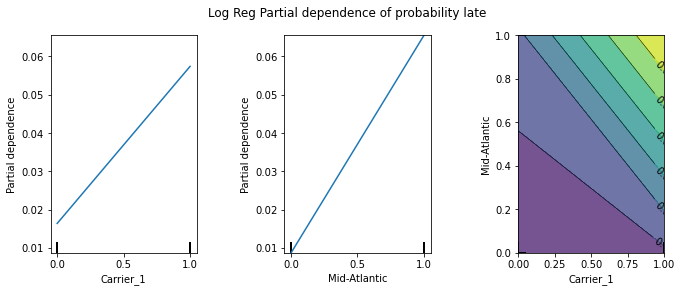

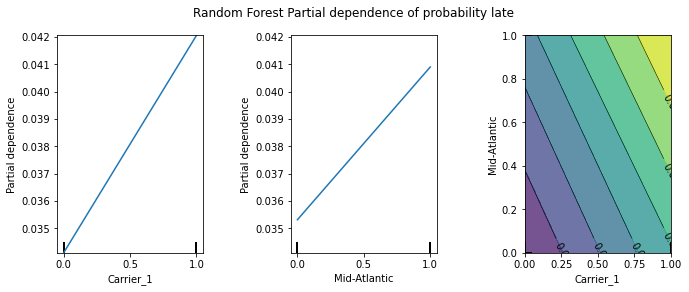

In [29]:
carrier1 = list(features).index('Carrier_1')
midatlantic = list(features).index('Mid-Atlantic')

features_plot = [carrier1, midatlantic, (carrier1, midatlantic)]

_, ax = plt.subplots(ncols=3, figsize=(11, 4))
display = plot_partial_dependence(reg_lin, X_train, features_plot, feature_names=features, n_jobs=3, grid_resolution=100,ax=ax)

display.figure_.suptitle('Log Reg Partial dependence of probability late')
display.figure_.subplots_adjust(wspace=0.6, hspace=0.5)

_, ax = plt.subplots(ncols=3, figsize=(11, 4))
display = plot_partial_dependence(forest, X_train, features_plot, feature_names=features, n_jobs=3, grid_resolution=20, ax=ax)

display.figure_.suptitle('Random Forest Partial dependence of probability late')
display.figure_.subplots_adjust(wspace=0.6, hspace=0.5)


As we can see from the above, both models indicate Carrier 1 as well as shipping to the Mid-Atlantic region are more prone to being late, especially when the two are combined. So when the shipping destination is in the Mid-Atlantic region, it would be wise not to use Carrier 1 and a different carrier instead.

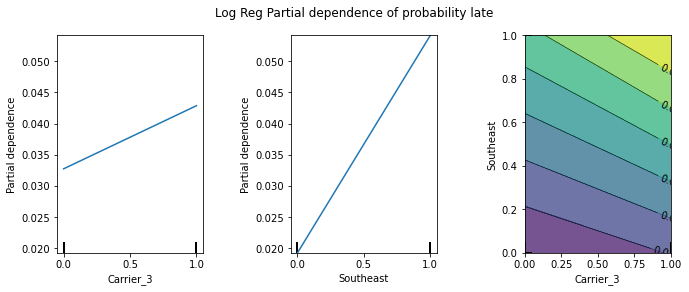

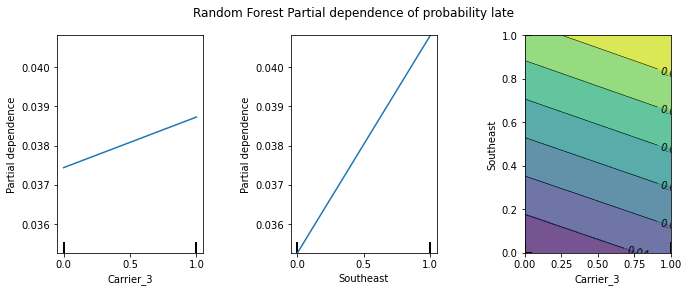

In [70]:
carrier3 = list(features).index('Carrier_3')
southeast = list(features).index('Southeast')


features_plot = [carrier3,southeast, (carrier3,southeast)]

_, ax = plt.subplots(ncols=3, figsize=(11, 4))
display = plot_partial_dependence(reg_lin, X_train, features_plot, feature_names=features, n_jobs=3, grid_resolution=20,ax=ax)

display.figure_.suptitle('Log Reg Partial dependence of probability late')
display.figure_.subplots_adjust(wspace=0.6, hspace=0.5)

carrier3 = list(features).index('Carrier_3')
southeast = list(features).index('Southeast')



_, ax = plt.subplots(ncols=3, figsize=(11, 4))
display = plot_partial_dependence(forest, X_train, features_plot, feature_names=features, n_jobs=3, grid_resolution=20,ax=ax)

display.figure_.suptitle('Random Forest Partial dependence of probability late')
display.figure_.subplots_adjust(wspace=0.6, hspace=0.5)

A similar trend appears for Carrier 3 and the Southeast region.

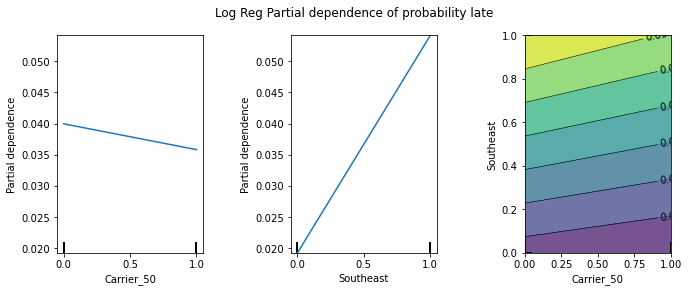

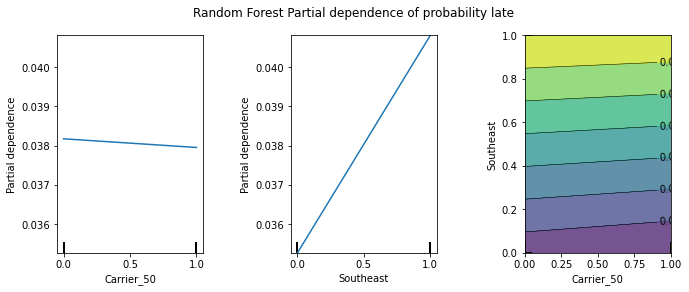

In [71]:
carrier50 = list(features).index('Carrier_50')
southeast = list(features).index('Southeast')


features_plot = [carrier50,southeast, (carrier50,southeast)]

_, ax = plt.subplots(ncols=3, figsize=(11, 4))
display = plot_partial_dependence(reg_lin, X_train, features_plot, feature_names=features, n_jobs=3, grid_resolution=20,ax=ax)

display.figure_.suptitle('Log Reg Partial dependence of probability late')
display.figure_.subplots_adjust(wspace=0.6, hspace=0.5)


_, ax = plt.subplots(ncols=3, figsize=(11, 4))
display = plot_partial_dependence(forest, X_train, features_plot, feature_names=features, n_jobs=3, grid_resolution=20,ax=ax)

display.figure_.suptitle('Random Forest Partial dependence of probability late')
display.figure_.subplots_adjust(wspace=0.6, hspace=0.5)

Switching to e.g. Carrier 50 when shipping to the Southeast region seems to be a better strategy.

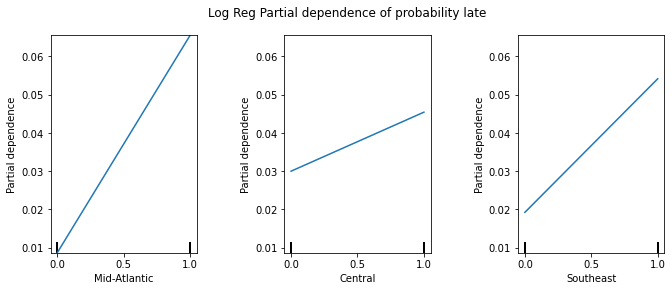

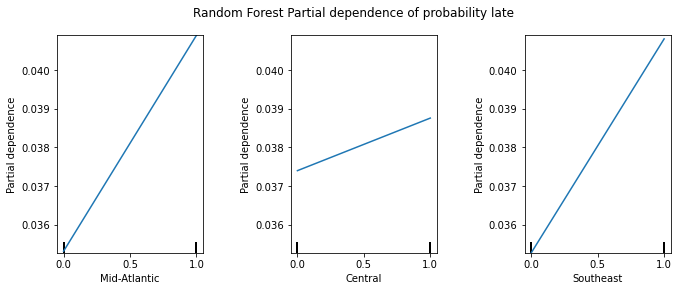

In [72]:
ma = list(features).index('Mid-Atlantic')
central = list(features).index('Central')
se = list(features).index('Southeast')


features_plot = [ma,central,se]

_, ax = plt.subplots(ncols=3, figsize=(11, 4))
display = plot_partial_dependence(reg_lin, X_train, features_plot, feature_names=features, n_jobs=3, grid_resolution=20,ax=ax)

display.figure_.suptitle('Log Reg Partial dependence of probability late')
display.figure_.subplots_adjust(wspace=0.6, hspace=0.5)

_, ax = plt.subplots(ncols=3, figsize=(11, 4))
display = plot_partial_dependence(forest, X_train, features_plot, feature_names=features, n_jobs=3, grid_resolution=20,ax=ax)

display.figure_.suptitle('Random Forest Partial dependence of probability late')
display.figure_.subplots_adjust(wspace=0.6, hspace=0.5)

The above suggests that when the shipping region is either of the three above, the probability of being late is slightly increased. The "West" region is not explicitly a column because its presence is encoded when all of the other three regions have a value of zero. We can conclude that shipping to the West region decreases the probability of a late arrival.

Suppose we want to predict whether a shipment will be late on a specific observation of our test set. We can get a force plot for the log of the odds of the event of being late using the Shap library:

In [73]:
explainer = shap.LinearExplainer(reg_lin, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)


In [74]:
ind = 1654
shap.force_plot(explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:], feature_names=X_train.columns)

In [75]:
#Check why log odds base value is off here. Should be around -3.25 not -10.28.

For this particular prediction our (log) of the odds of being late is above the base value, meaning the corresponding probability of a late shipment is higher than average. The relative contributions of each feature for this are indicated. We see that the weight being less than the average weight of 0 (data has been standardized), plays a favorable role but not enough to beat the baseline, while the regions do not. A clear strategy is to either use a different carrier or further reduce the weight of the shipment if feasible.


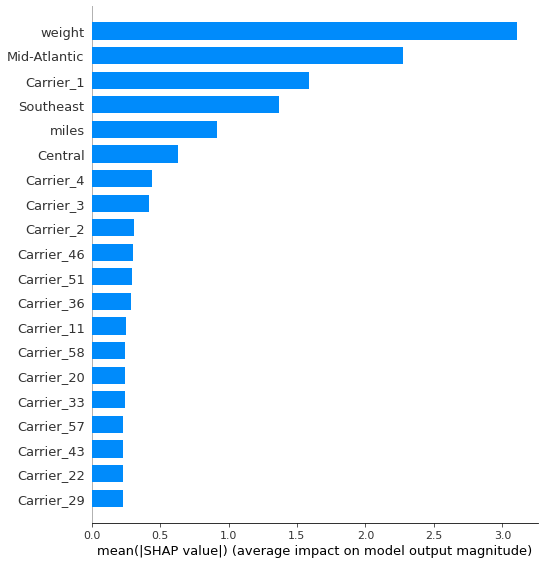

In [76]:
shap.summary_plot(shap_values,  X_test, plot_type="bar")

The mean Shap values displayed above are consistent with the results of our feature selection work from before.

### Long Term Business Insights:

-From above it's clear that the only region with a favorable impact on timely arrival is the West. An intervention for the manufacturer might be to split up inventory so that more stock is available in locations closer to the West, since mileage is also an important feature. However, splitting up inventory across locations does not happen overnight, making this a long term strategy. 

-When it's time for the manufacturer to decide where to open up new locations or close existing ones, the same regional considerations above apply. In case most of the retailers are not near the West region, then choosing the right carrier in addition to splitting up heavier loads is helpful. Thanks to the PDP plots, we can identify the right combination of regions/carriers!

-If the above short term business strategies are applied correctly, it can be expected that as the model is updated over time, the importance of the aforementioned features will diminish. 

## Conclusion

While accurate predictions are an important part of business strategy, they are useless without an additional means of affecting the outcome, which is what feature importance can be used for. In this discussion we gave an overview of two popular feature importance techniques in the context of the CPG industry. 

We defined partial dependence plots (PDPs) and Shap values, showed how to interpret them, as well illustrated their pros and cons via explicit examples. Finally, we gave a detailed case study demonstrating how to apply PDPs and Shap values to derive both long term and short term business strategies for the problem of timely shipments from a manufacturer to a retailer.   

## Aside (to be removed): Experimenting with PDPbox for better PDP plots 

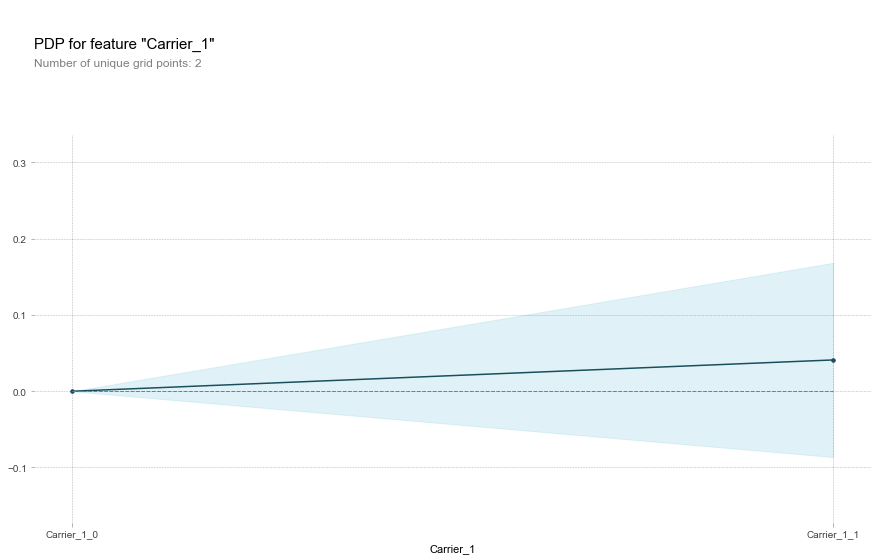

In [68]:
from pdpbox import pdp

pdp_carrier1 = pdp.pdp_isolate(model=reg_lin, dataset=X_train, model_features=features, feature='Carrier_1')

fig, axes = pdp.pdp_plot(pdp_carrier1, 'Carrier_1')

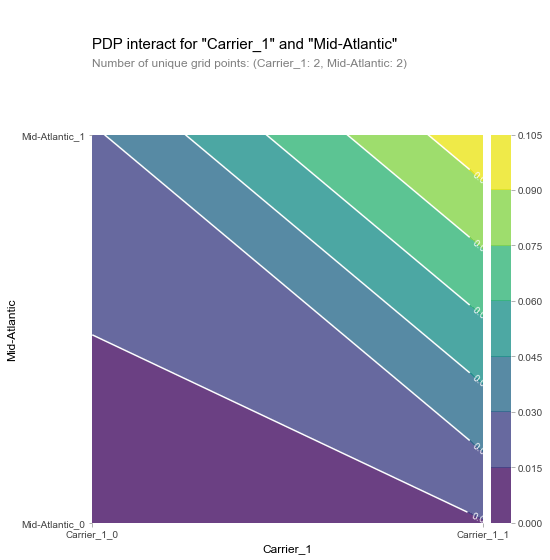

In [69]:
inter_rf = pdp.pdp_interact(model=reg_lin, dataset=X_train, model_features=features,features=['Carrier_1', 'Mid-Atlantic'])

fig, axes = pdp.pdp_interact_plot(inter_rf, ['Carrier_1', 'Mid-Atlantic'], x_quantile=True, plot_type='contour', plot_pdp=False)